In [1]:
import sys
import os, errno
import os.path as osp
import glob
import re
import logging
handler = logging.FileHandler(filename='important_log.log', mode='a')
sys.path.insert(0,'/users/cmofokeng/rgz_rcnn/tools/')

import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import unique
from astropy.io.votable import parse_single_table
#from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

from astropy.coordinates import SkyCoord
from scipy.ndimage import center_of_mass,mean
from astropy.stats import SigmaClip,sigma_clipped_stats
#from astropy.stats import 
#from util import robust_sigma
#from skimage.measure import moments
#from skimage.measure import label, regionprops
from IPython.display import display, Image
import matplotlib.patches as patches
import preprocess_toolset as ppt
from photutils import centroid_com, centroids
from astropy.wcs import WCS
from astropy.io import fits
from fuse_radio_ir import fuse, _get_contour
import make_contours
from matplotlib.path import Path
#from functions import meanclip
from photutils import detect_threshold, detect_sources, source_properties

import cv2

In [2]:
def overlay_centroids(pred_pos,bg_png,countp_png,fits_f,fits_f_wise,hosts_file,radio_catalog):
    """
    This fuction overlays the given position of the IR hosts given the
    output from ClaRAN and use the image to get the estimate of geometric centre and center-of-mass of pixels.
    
    pred_pos - a csv file containg output from ClaRAN; predicted class,probability value,bounding box coordinates - x1, y1, x2, y2.
                where bottom-left corner coordinates are x1,y1 and top right corner coordinates are x2,y2
    fits_file - FITS image of the radio source
    bg_png - PNG of radio/IR image used on ClaRAN
    hosts_file - a csv file containg position (RA,Dec) of the IR source from the catalog 
    
    Returns - PNG image showing ClaRAN output overlaid with IR hosts position
    """
    
    radius = 2.7777777854E-4*181 # This is the product CDELT value from FITS Header and image size of the original input cutout
    
    match = 0
    nms_keep = []
    cat_sources = []
    fov = []
    
    # Read the backgorund image
    im = cv2.imread(bg_png)
    im_cp = cv2.imread(countp_png)
    
    
    # Output filename
    Output_overlay = pred_pos.replace(".csv","_hosts-overlay.png")
    
    sid = 0
    cd = osp.basename(pred_pos)
    typ = ""
    if (cd.endswith("_D1.csv")):
        cd = cd.replace("gmrt_en1w610_clipped_","")
        cd = cd.replace("_D1.csv","")
        typ = "D1"
        sid = int(cd)
        
    else:
        typ = "D4"
        cd = cd.replace("gmrt_en1w610_clipped_","")
        cd = cd.replace(".csv","")
        
        sid = int(cd)   
    
    # Read position of IR hosts
    #data = np.loadtxt(hosts_file,delimiter=',',skiprows=1)
    data = ascii.read(hosts_file)
    data = data.to_pandas()
    
    hosts_ids = data["source_id"].to_numpy()
    hosts_ids = np.array([re.sub("'","",s.replace("b","")) for s in hosts_ids])
    ra = data["ra"].to_numpy()
    dec = data["dec"].to_numpy()
    
    # Transforming the coordinates to standard coordinates
    position = SkyCoord(ra,dec, frame='icrs', unit ='deg')
    #center = SkyCoord(RAs,Decs, frame='icrs', unit ='deg')

    # Get header information from FITS file to transform pixel scales
    #wcsradio = WCS(fits_f, naxis=2)
    
    with fits.open(fits_f) as file:
        hduradio = file[0]
        wcsradio = WCS(hduradio.header, naxis=2)
        fits_data = hduradio.data
        
        xscale = abs(hduradio.header['CDELT1'])
        yscale = abs(hduradio.header['CDELT2'])
            
        xpix = hduradio.header['NAXIS1']
        ypix = hduradio.header['NAXIS2']
            
        xsize = xscale*xpix
        ysize = yscale*ypix
        #wcs = WCS(hduradio.header).dropaxis(3).dropaxis(2)
    #threshold = detect_threshold(fits_data, snr=3)
    #radio_data = detect_sources(fits_data, threshold, npixels=5)
        
    # Stats of the FITS file
    mean, median, std = sigma_clipped_stats(fits_data)
    
    # boundary values of the 3-sigma clip
    #lower_thresh = median-3*std
    upper_thresh = median+3*std
    
    
    # Transform coordinates to pixel
    position_pix = position.to_pixel(wcsradio);
    #print(position_pix)
    
    y_pix = hosts_overlay(0,position_pix[1],im.shape[0]/2,im.shape[0]/2,-np.pi)
    position_pix = np.array([position_pix[0],y_pix[1]])
    
    #print(len(position_pix))
    in_img = np.logical_and(position_pix[0]<181.00, position_pix[1]<181.00)
    
    #print(in_img)
    
    #sources_in_img = source_inbbox(position_pix,0.0,)
    position_pix = np.array([position_pix[0][in_img],position_pix[1][in_img]])
    
    #fits_img = cv2.imread(fits_data)
    #print(fits_data.shape)
    source_ra = 0.0
    source_dec = 0.0
    source = ""
    t = parse_single_table(radio_catalog)
    catalog_data = t.to_table(use_names_over_ids=True)
    
    for i in range(len(catalog_data['RA_deg'])):
        #ra_s = "%.2f"%data['RA_deg'][i]
        #dec_s = "%.2f"%data['Dec_deg'][i]
        source_id = catalog_data['Source_id'][i]
        #print(type(source_id),type(sid))
        if source_id == sid:
            source = str(source_id)
            source_ra = catalog_data['RA_deg'][i]
            source_dec = catalog_data['Dec_deg'][i]
            #cat_sources.append([source_ra,source_dec])
            for j in range(len(catalog_data)):
                fov = []

                ra = catalog_data["RA_deg"][j]
                dec = catalog_data["Dec_deg"][j]
                
                x = ra - source_ra
                y = dec - source_dec


                distance = np.sqrt(x*x + y*y) # calculate the distance

                if distance<radius: # take only cataloged sources that are in the same FOV
                    match+=1
                    fov.append(j) 

                if match>=1: # in some FOVs only one source is found, skip it.
                    #dets = []
                    fov = np.array(fov)
                    same_fov_data = catalog_data[fov] # retrieve data that belongs to the same FOVs
                    
                    for k in range(len(same_fov_data)):
                        cat_sources.append([same_fov_data[k]["RA_deg"],same_fov_data[k]["Dec_deg"]])


    #cat_sources.append([source_ra,source_dec])
    same_fov_cat = np.array(cat_sources)
    #sky_same_fov = deg2world(same_fov_cat,wcsradio)
    sky_same_fov = SkyCoord(same_fov_cat[:,0],same_fov_cat[:,1], frame='icrs', unit ='deg')
    sources_pix = sky_same_fov.to_pixel(wcsradio);
    source_y_pix = hosts_overlay(0,sources_pix[1],im.shape[0]/2,im.shape[0]/2,-np.pi)
    sources_pix = np.array([sources_pix[0],source_y_pix[1]])
    
    #sources_pix = sources_pix[sources_pix<im.shape[0]]
    
    source_poss = SkyCoord(source_ra,source_dec, frame='icrs', unit ='deg')
    #source_poss_string = source_poss.to_string("decimal")
    
    #source_poss_pix = source_poss.to_pixel(wcsradio)
    #source_poss_pix_coords = source_poss_pix #
    
    # Plot the results
    fig = plt.figure(figsize=(10,10),dpi=150)
    #fig.set_size_inches(600 / my_dpi, 600 / my_dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_xlim([0, im.shape[0]])
    #ax.set_ylim([0,im.shape[0]])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.set_aspect('equal')
    #im = cv2.resize(im, (600, 600))
    im = im[:, :, (2, 1, 0)]
    
    # Read ClaRAN output from csv file
    #df = pd.read_csv(hosts_pos)
    pred_sources = ascii.read(pred_pos)
#     pred_class = []
#     pred_scores = []
    
    CM = []
    
    GC = []
    
    ir_host_ids = []
    ir_host_ids_gc = []
    ir_host_ids_pc = []
    
    poss_host = []
    poss_host_gmrt = []
    poss_host_geo = []
    
    poss_host_pix = []
    poss_centre_pix = []
    poss_centre_geo = []
    
    found_host = False
    found_host_center = False

    if(len(pred_sources)!=0):
        for i in range(len(pred_sources)):

            cl = pred_sources['class'][i]
    #         pred_class.append(cl)


            prob_score = pred_sources['scores'][i]
    #         pred_class.append(prob_score)

            # Bounding box coordinates from ClaRAN were scaled up to a given scale, in this case 600
            bbox = np.array([pred_sources['x1'][i],pred_sources['y1'][i],pred_sources['x2'][i],pred_sources['y2'][i]])
            
            # So they need to be down-scaled
            bbox /= (float(600)/float(im.shape[0]))
            #bbox = bbox 1.00 
            width = int(bbox[2]-bbox[0])
            height = int(bbox[3]-bbox[1])
            
            #print(bbox)
            y1_flip = hosts_overlay(0,bbox[1],im.shape[0]/2,im.shape[0]/2,np.pi)
            y2_flip = hosts_overlay(0,bbox[3],im.shape[0]/2,im.shape[0]/2,np.pi)
            
            #y2 = hosts_overlay(0,y2_flip[1],height/2,height/2,-np.pi)
            
            ymin_index = y2_flip[1]-1
            xmin_index = bbox[0]-1
            
            cp_fits_roi = fits_data[int(ymin_index):int(y1_flip[1]),int(xmin_index):int(bbox[2])]
            cp_fits_roi[cp_fits_roi<upper_thresh] = 0.0
            #cp_fits_roi = clean_radio[int(ymin_index):int(y1_flip[1]),int(xmin_index):int(bbox[2])]
            com_fits_radio = np.array(center_of_mass(cp_fits_roi)) #+ np.array([bbox[1],xmin_index])
            #com_fits_radio =np.array(center_of_mass(cp_fits_roi)) #+ np.array([bbox[1],xmin_index])
            cp_fits = np.array([bbox[3],xmin_index]) + np.array([-com_fits_radio[0],com_fits_radio[1]])
            #cp_fits = np.array([bbox[3],xmin_index]) + np.array([-com_fits_radio[0],com_fits_radio[1]])

            gc = np.array([cp_fits[1],cp_fits[0]])

            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='blue', linewidth=1.0)
            )

            ax.text(bbox[0], bbox[1] - 2,
                        '{:s} {:.2f}'.format(cl, prob_score),
                        bbox=dict(facecolor='None', alpha=0.4, edgecolor='None'),
                        fontsize=16, color='white')
            
            #print(cp)
            ind = source_inbbox(position_pix,bbox[0],bbox[1],bbox[2],bbox[3])

            host_name = hosts_ids[ind]
            host_ra = position_pix[0][ind]
            host_dec = position_pix[1][ind]

            poss_source_dis = np.zeros(len(host_ra))
                    #print(ind_centre)
            #poss_pix_centre_dis = np.zeros(len(host_ra))
            poss_geo_centre_dis = np.zeros(len(host_ra))

            if (len(poss_source_dis)!=0):
                found_host = True
                for i in range(len(host_ra)):
                    pos = [host_ra[i],host_dec[i]]

                    min_dis_source_geo = ((gc[0]-pos[0])**2 + (gc[1]-pos[1])**2)**2

                    poss_geo_centre_dis[i] = min_dis_source_geo

                i_centre_geo = np.where(poss_geo_centre_dis==min(poss_geo_centre_dis))[0]

                ir_host_ids_gc.append(host_name[i_centre_geo])
                #print(ir_host_ids_gc)
                poss_centre_geo.append([host_ra[i_centre_geo],host_dec[i_centre_geo]])

            #host_found = host_inbbox(source_poss_pix,bbox[0],bbox[1],bbox[2],bbox[3])
            gmrt_host = source_inbbox(sources_pix,bbox[0],bbox[1],bbox[2],bbox[3])
            #found_host_center = host_found
            
            gmrt_ra = sources_pix[0][gmrt_host]
            gmrt_dec = sources_pix[1][gmrt_host]
            
            poss_source_dis = np.zeros(len(host_ra))
            #print(poss_source_dis)
    #         i_host = np.where(poss_source_dis==min(poss_source_dis))[0][0]
            if (len(gmrt_ra)!=0):
                for i in range(len(gmrt_ra)):
                    pos_gmrt = [gmrt_ra[i],gmrt_dec[i]]
                
                    if (len(poss_source_dis)!=0):

                        for i in range(len(host_ra)):
                            pos = [host_ra[i],host_dec[i]]
                            min_dis_source = ((pos_gmrt[0]-pos[0])**2 + (pos_gmrt[1]-pos[1])**2)**2
                            poss_source_dis[i] = min_dis_source
                            
                            
                        i_host = np.where(poss_source_dis==min(poss_source_dis))[0][0]
                        ir_host_ids.append(host_name[i_host])
                        poss_host.append([host_ra[i_host],host_dec[i_host]])

            
            GC.append(gc)

        GC = np.array(GC)

        gc = deg2world(GC,wcsradio)  #[l.split() for l in gc_string]

        hosts = np.array(poss_host)

        centre_geo = np.array(poss_centre_geo)
        #print(source_pix)


        #print(poss_host)
        source_ID = "Source_ID: " + source
        #ax.annotate(source_ID, xy=(0.45,0.97), xycoords='axes fraction', color='w', fontsize=14)

        coords = "RA, Dec: {:.4f} {:.4f} [degrees] (center)".format(source_ra,source_dec)
        #ax.annotate(coords, xy=(0.45,0.95),xycoords='axes fraction', color='w', fontsize=14)


        scale = 1.0
        show_img_size = im.shape[0]

        scal = "scale: %.2f' x %.2f' (%.2fx%.2f pix)"%((xsize/scale)*60,(ysize/scale)*60,show_img_size,show_img_size)
        #ax.annotate(scal, xy=(0.02,0.97), xycoords='axes fraction', color='w', fontsize=14)

        patch_contour = fuse(fits_f, im, None, sigma_level=4, mask_ir=False,
                                 get_path_patch_only=True)

        
        ax.scatter(GC[:,0],GC[:,1],s=260,c='blue',marker='+',label='RC')

        ax.scatter(sources_pix[0],sources_pix[1],s=260,c='lime',marker='+',label='PyBDSF')
    
        


        if (bg_png.endswith("_logminmax.png")):
            ax.imshow(im)
            ax.add_patch(patch_contour)

            ax.scatter(position_pix[0],position_pix[1],s=260,c='black',marker='x',label='IR host')
            if found_host:
                #centre_geo_coords = deg2world(centre_geo,wcsradio)
                ax.scatter(centre_geo[:,0],centre_geo[:,1],s=260,c='blue',marker='o',alpha=0.35,label='IR host (RC)')

                centre_pix_coords = deg2world(centre_pix,wcsradio)
                #ax.scatter(centre_pix[:,0],centre_pix[:,1],s=215,c='lime',marker='o',alpha=0.35,label='IR host (IC)')

                #print(len(hosts))
                if (len(hosts)!=0):

                    ax.scatter(hosts[:,0],hosts[:,1],s=260,c='lime',marker='v',alpha=0.35,label='IR host (PyBDSF)')

                    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

                else:
                    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

            else:
                ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

            #return source,[float(source_poss_string.split()[0]),float(source_poss_string.split()[1])],cm,gc

        elif (bg_png.endswith("_infrared.png")):
            #ax.imshow(np.flipud(im), origin='lower') # because the pixel coordinates start at (0,0) whereas
                                                     # FITS images starts at (1,1)

            ax.set_ylim([im.shape[0],0])
            ax.add_patch(patch_contour)
            ax.imshow(im, origin='upper')
            ax.scatter(position_pix[0],position_pix[1],s=260,c='black',marker='x',label='IR host')
            if found_host:
                centre_geo_coords = deg2world(centre_geo,wcsradio)
                ax.scatter(centre_geo[:,0],centre_geo[:,1],s=260,c='blue',marker='o',alpha=0.35,label='IR host (RC)')

                if (len(hosts)!=0):
    #                 print(hosts)
                    host_coords = deg2world(hosts,wcsradio)
                    ax.scatter(hosts[:,0],hosts[:,1],s=260,c='lime',marker='v',alpha=0.35,label='IR host (PyBDSF)')
                    #print([float(source_poss_string.split()[0]),float(source_poss_string.split()[1])])
                    #print(ir_host_ids_pc)
                    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

                else:
                    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

            else:
                ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=22, borderaxespad=0)

        else:
            print("error...")
            # Do not do anything
    plt.show()


In [3]:
def central_coords(arr,height):
    
    dis = (height/2)-arr[0]
    
    if dis>0:
        arr = arr + np.array([-dis*2,0.0])
        return arr
    else:
        return arr

In [4]:
def hosts_overlay(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=np.cos(theta)*(x-xo)-np.sin(theta)*(y-yo)   + xo
    yr=np.sin(theta)*(x-xo)+np.cos(theta)*(y-yo)  + yo
    return np.array([xr,yr])

In [5]:
def deg2world(poss_array,wcs_info):
    print(poss_array.shape)
    
    coords_string = []
    
    coords_world = SkyCoord.from_pixel(poss_array[:,0],poss_array[:,1],wcs_info)
    coords_string = coords_world.to_string("decimal")
    
    coords = []
    #print(type(coords_string))
    if isinstance(coords_string,np.ndarray):
        for i in range(len(coords_string)):
            string = coords_string[i]
            for c in string:
                #print(c)
                coords.append(c.split())
            #coords.append()
    if isinstance(coords_string,list):
        for l in coords_string:
            coords.append(l.split())   

    
    return np.array(coords)

In [6]:
def host_inbbox(position,x1,y1,x2,y2):
    
    ra_cond = np.logical_and(position[0]>x1,position[0]<(x1 + (x2 - x1)))
    dec_cond = np.logical_and(position[1]>y1,position[1]<(y1 + (y2 - y1)))
    
    return np.logical_and(ra_cond,dec_cond)

In [7]:
def source_inbbox(position,x1,y1,x2,y2):
    
    ra_cond = np.logical_and(position[0]>x1,position[0]<(x1 + (x2 - x1)))
    dec_cond = np.logical_and(position[1]>y1,position[1]<(y1 + (y2 - y1)))
    
    i_true = np.where(np.logical_and(ra_cond,dec_cond)==True)[0]
    
    return i_true

In [8]:
def centroid(im,x0,y0,x1,y1):
    """
    This function takes an image and the coordinates of the bounding box and then computes a center of mass on the pixel values 
    and output their respective x,y coordinates
    
    The fucntion takes:
    im - image of interest, that is to be used to get the centroid.
    (x0,y0) - coordinates of the bottom left corner of the bounding box
    (x1,y1) - coordinates of the upper top right corner of the bounding box
    
    Returns:
    2 arrays of x,y coordinates of the pixel centroid and the  geometric center of the bounding box.
    """
    
    roi_img = im[int(x0):int(x1),int(y0):int(y1),:] # taking only ROI bounded by the given box.
    
    com = center_of_mass(roi_img)[:2] # since we dealing with 3 channel images, we focus only only 2Dc coordinates (x,y)
    #print(com)
    gc = [x0+(x1-x0)/2,y0+(y1-y0)/2] # geometric center of the bounding box
    
    # Converting the coordinates to the full image coorndinates
    X = com[0]+x0 
    Y = com[1]+y0

    return [X,Y],gc
    

In [9]:
# load the final catalog with overlapping and edge detections removed
df = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_edge_catalogue_v3.csv")

In [10]:
df["Source_ID"].nunique()

4765

In [11]:
random_df = df.sample(n=1)

In [12]:
random_df

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
888,1830,1C_1P,0.9939,244.4913,55.3041,244.4878,55.3065,244.4896,55.3052,244.4895,55.3052


In [14]:
parent_dir = "/idia/users/cmofokeng/data/gmrt/"
data_dir = osp.join(parent_dir,"split_fits/test_1deg")
output_png_dir = osp.join(parent_dir,"output_gmrt")
ir_csv_dir = osp.join(parent_dir,"split_fits/position")

radio_catalog = osp.join(parent_dir,"en1w610-5sg9-clean-offset.vot")

prefx_name = "gmrt_en1w610_clipped_" + str(random_df["Source_ID"].iloc[0])

In [15]:
fits_radio = ir_img = osp.join(data_dir, prefx_name+".fits")
fits_ir = ir_img = osp.join(data_dir, prefx_name+"_0_wise_regrid.fits")
claran_csv = osp.join(output_png_dir, prefx_name+".csv")
ir_sources_positions =  osp.join(ir_csv_dir, prefx_name+".csv")
ir_img = osp.join(data_dir, prefx_name+"_infrared.png")
radio_img = osp.join(data_dir, prefx_name+"_logminmax.png")

(3, 2)
(2, 2, 1)
(2, 2)


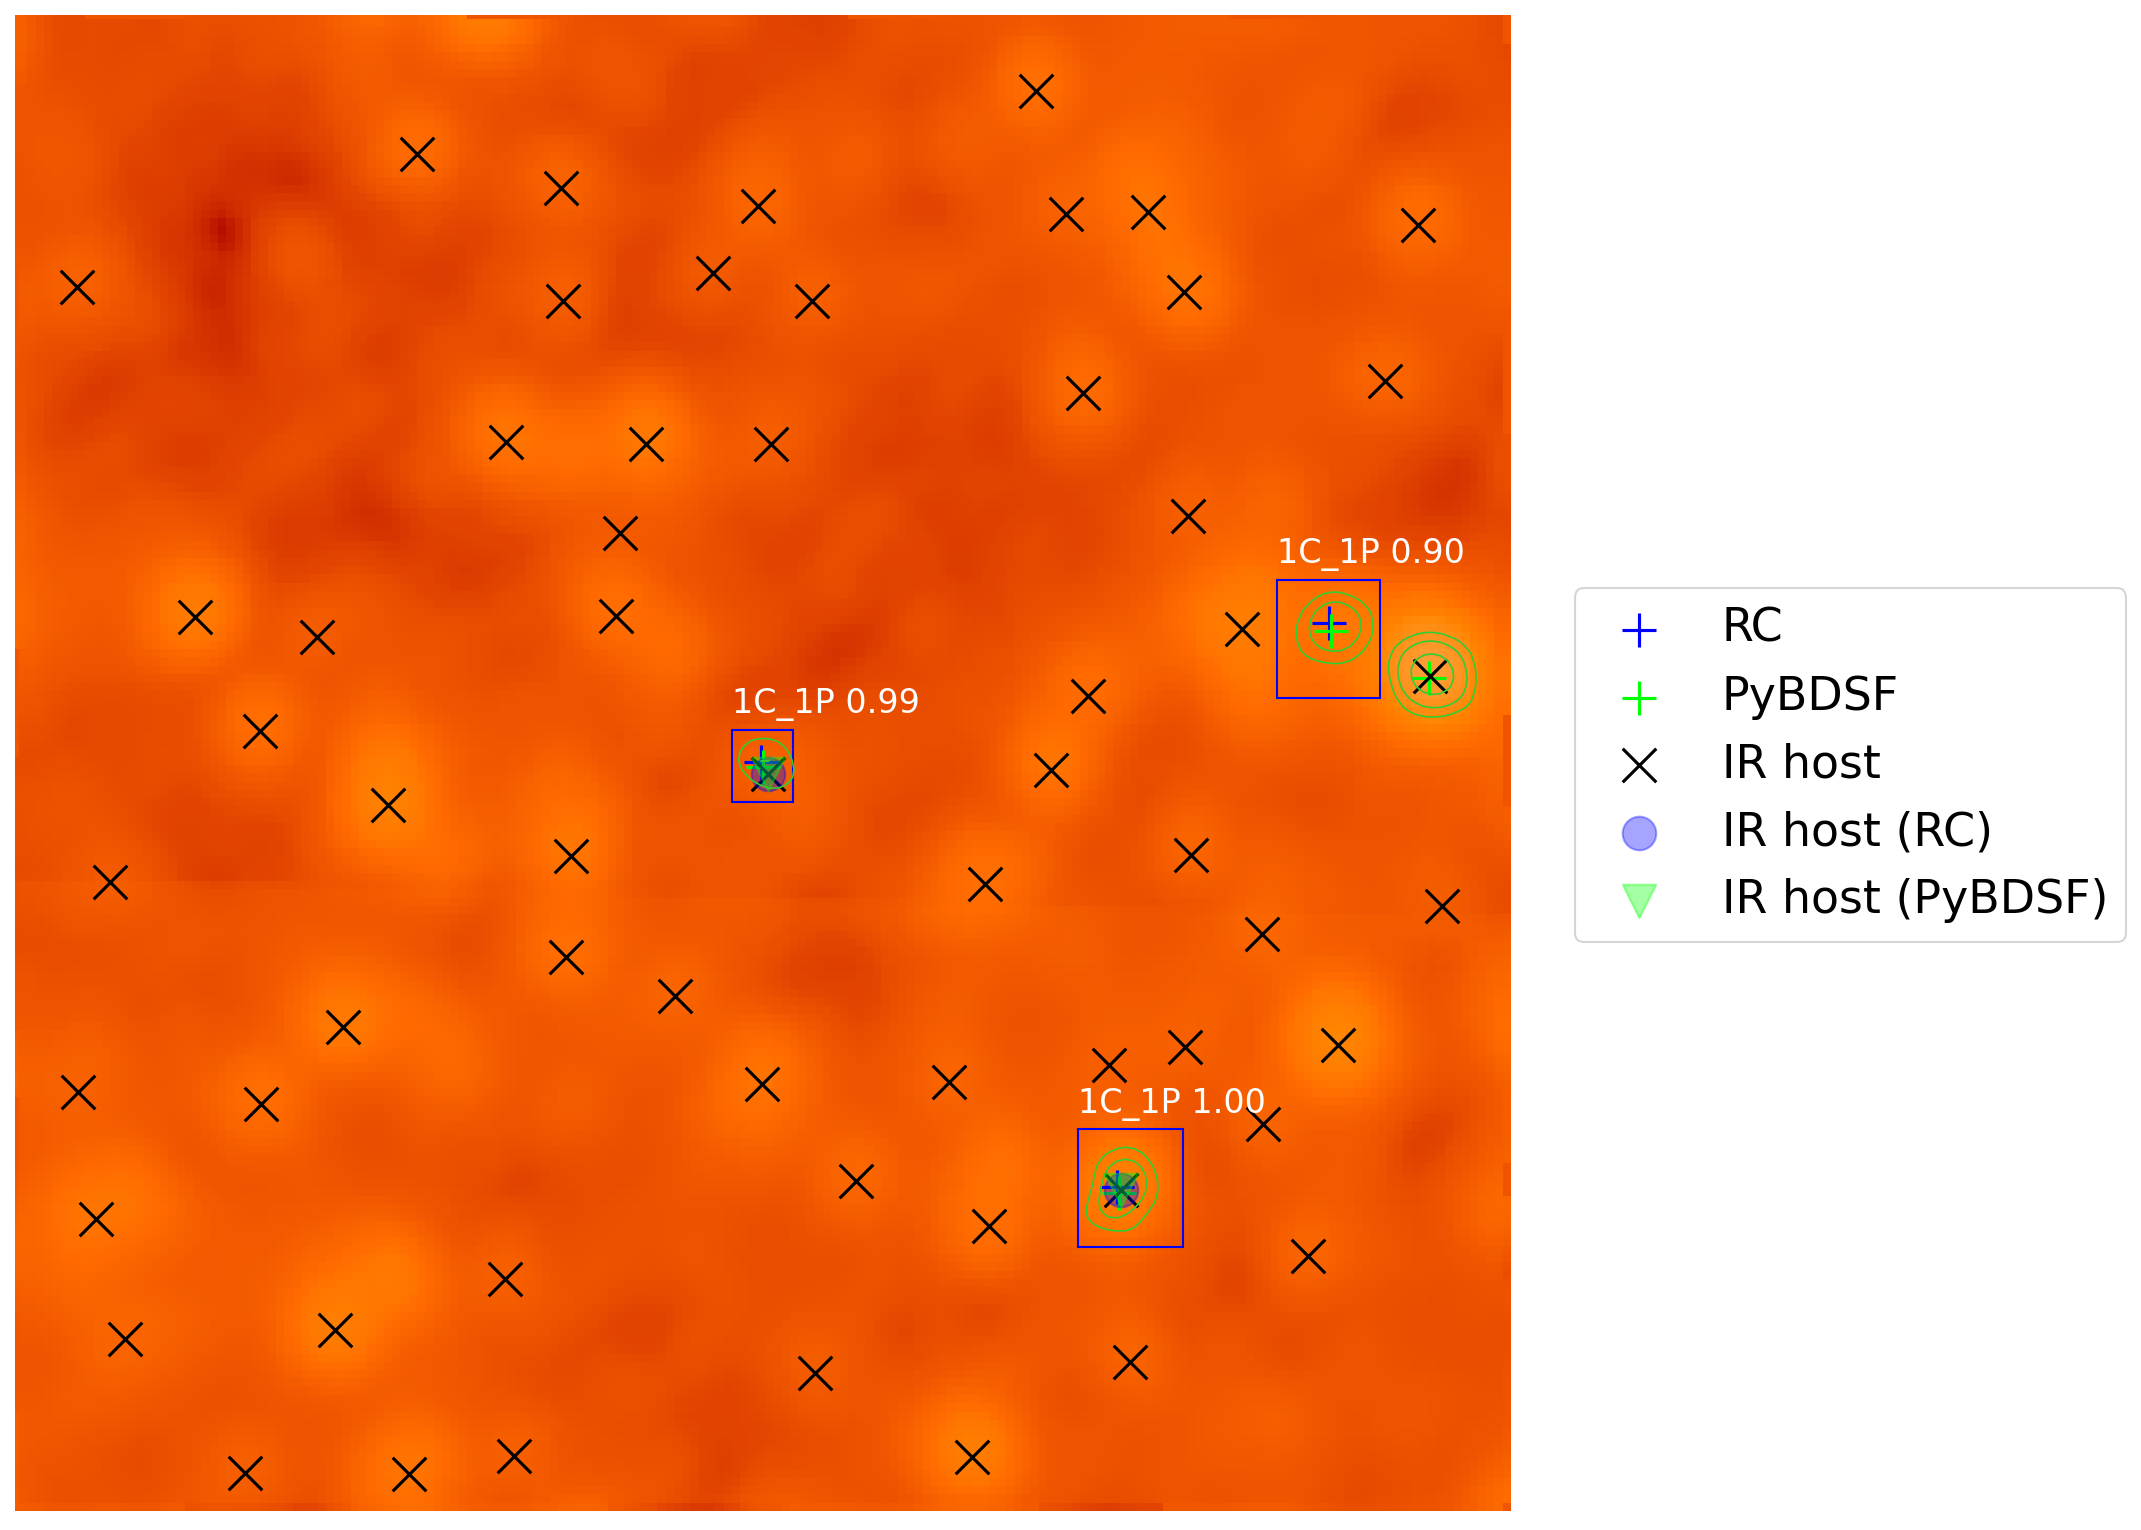

In [16]:
overlay_centroids(claran_csv,ir_img,radio_img,fits_radio,fits_ir,ir_sources_positions,radio_catalog)

(2, 2)
(2, 2, 1)
(4, 2)


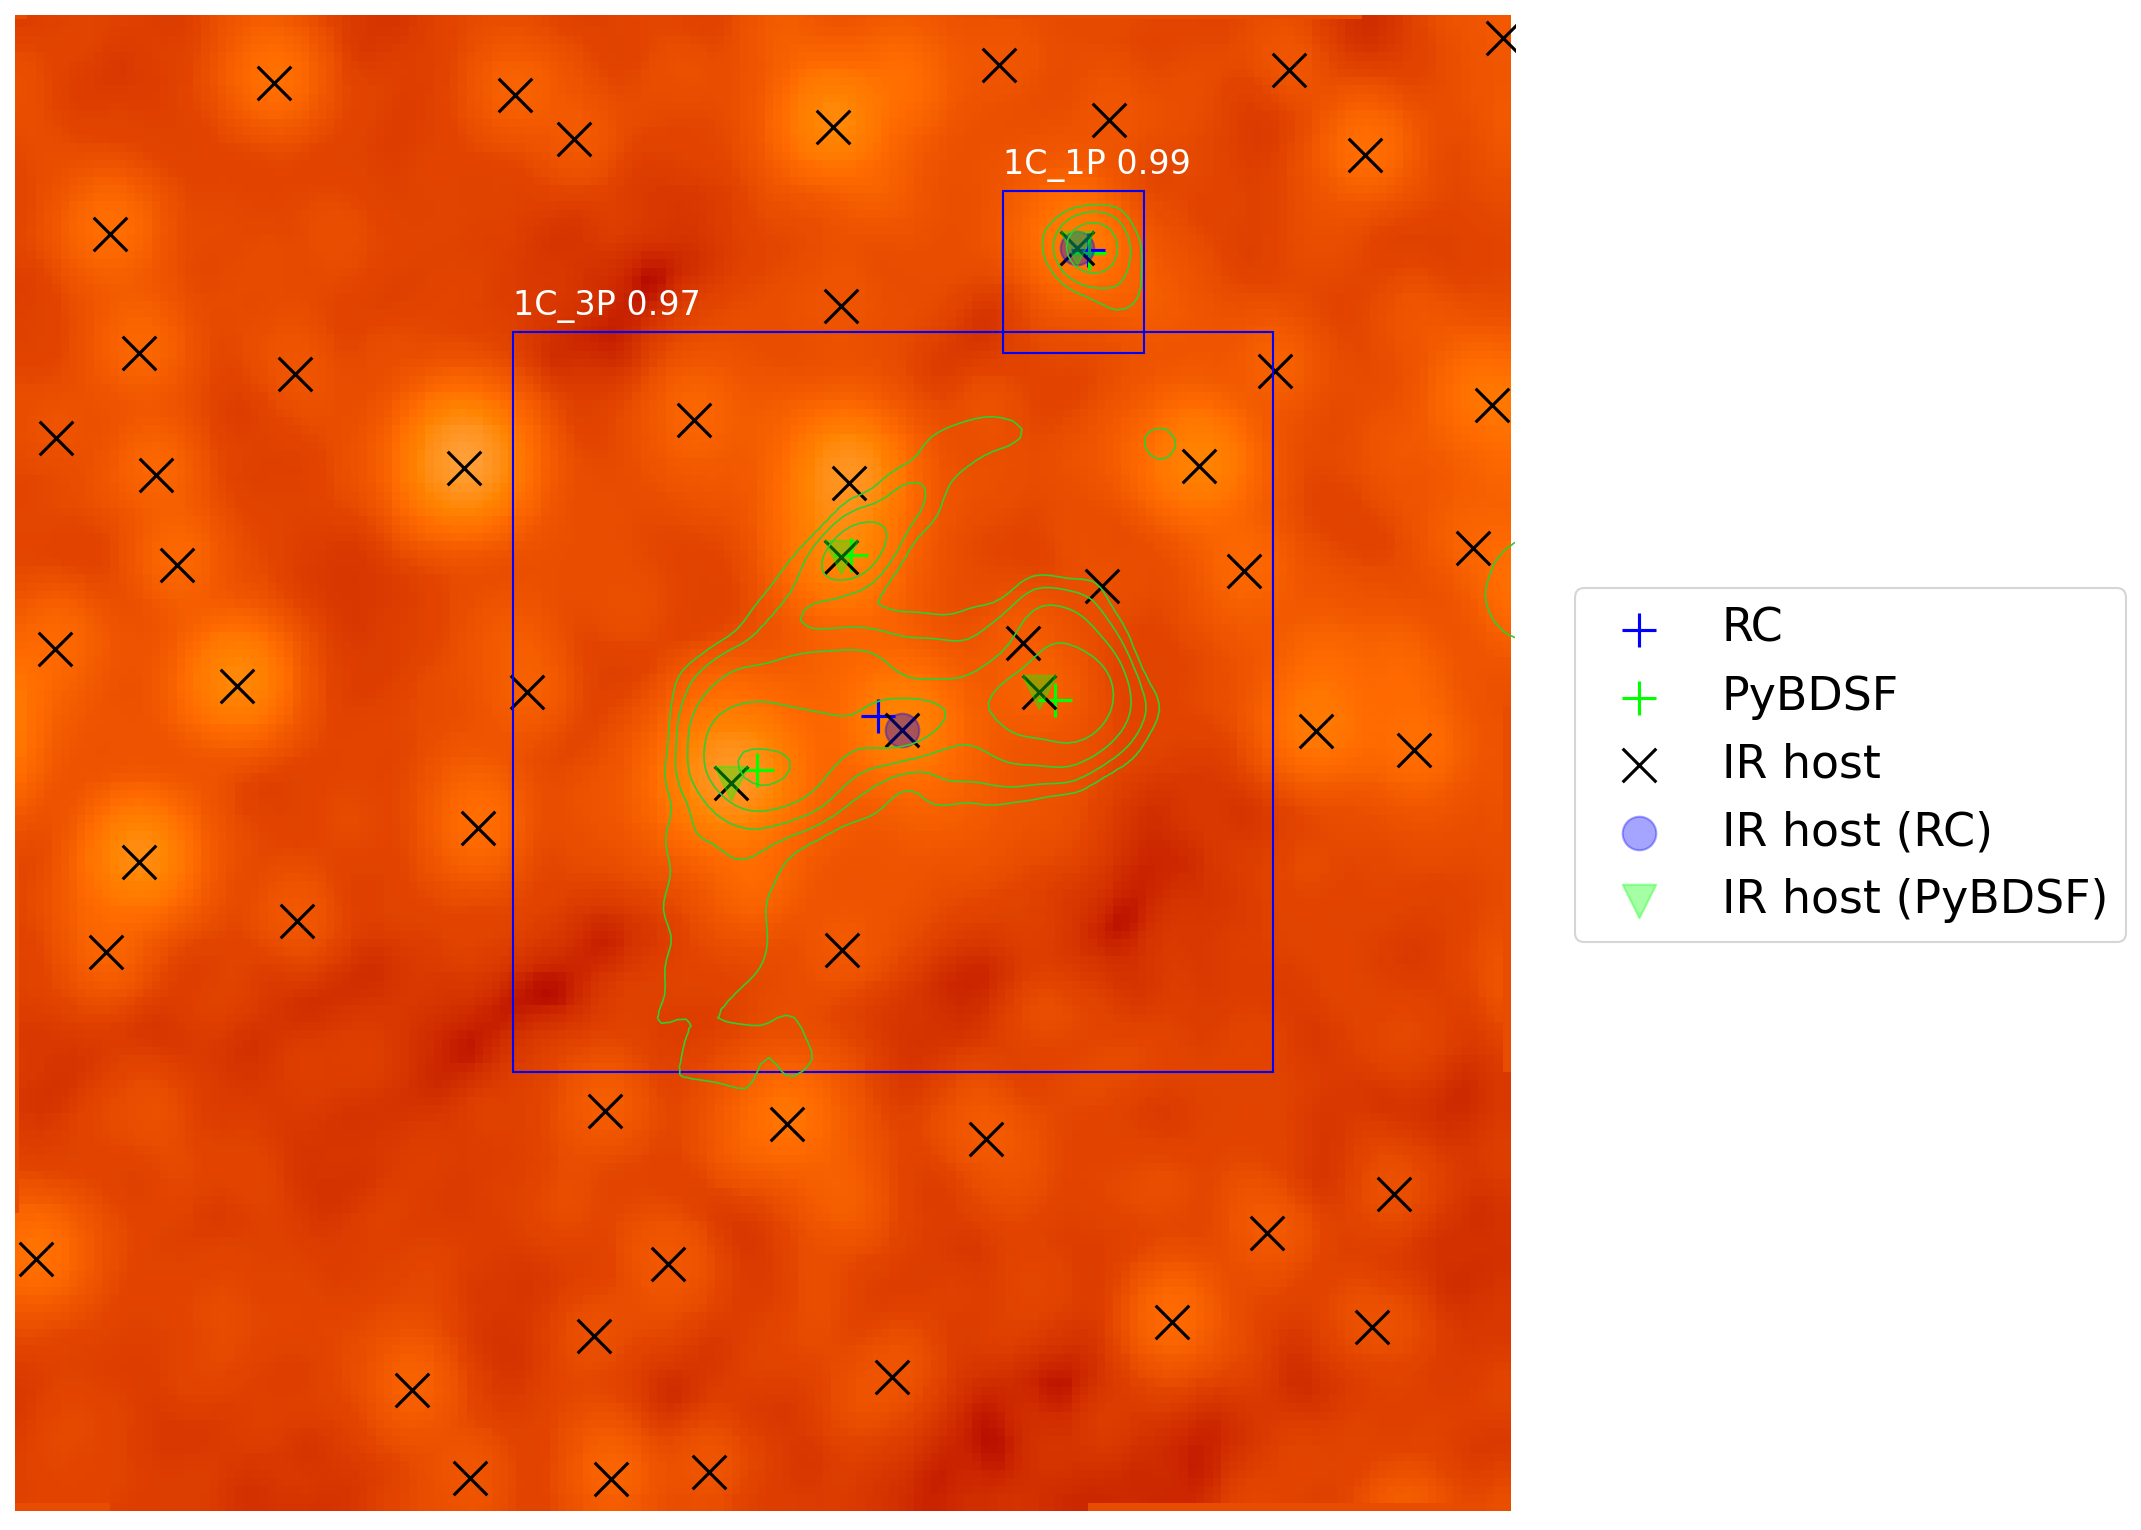

In [45]:
ClaRAN_file = "/idia/users/cmofokeng/data/gmrt/output_gmrt/gmrt_en1w610_clipped_3269.csv"
ir_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_3269_infrared.png"
radio_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_3269_logminmax.png"
hosts_file = "/idia/users/cmofokeng/data/gmrt/split_fits/position/gmrt_en1w610_clipped_3269.csv"
fits_f = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_3269.fits"
fits_f_w = "/idia/users/cmofokeng/data/gmrt/split_fits/wise_1deg/gmrt_en1w610_clipped_3269_0_wise_regrid.fits"
rad_catalog = "/idia/users/cmofokeng/data/gmrt/en1w610-5sg9-clean-offset.vot"
overlay_centroids(ClaRAN_file,ir_img,radio_img,fits_f,fits_f_w,hosts_file,rad_catalog)

(5, 2)
(4, 2, 1)
(8, 2)


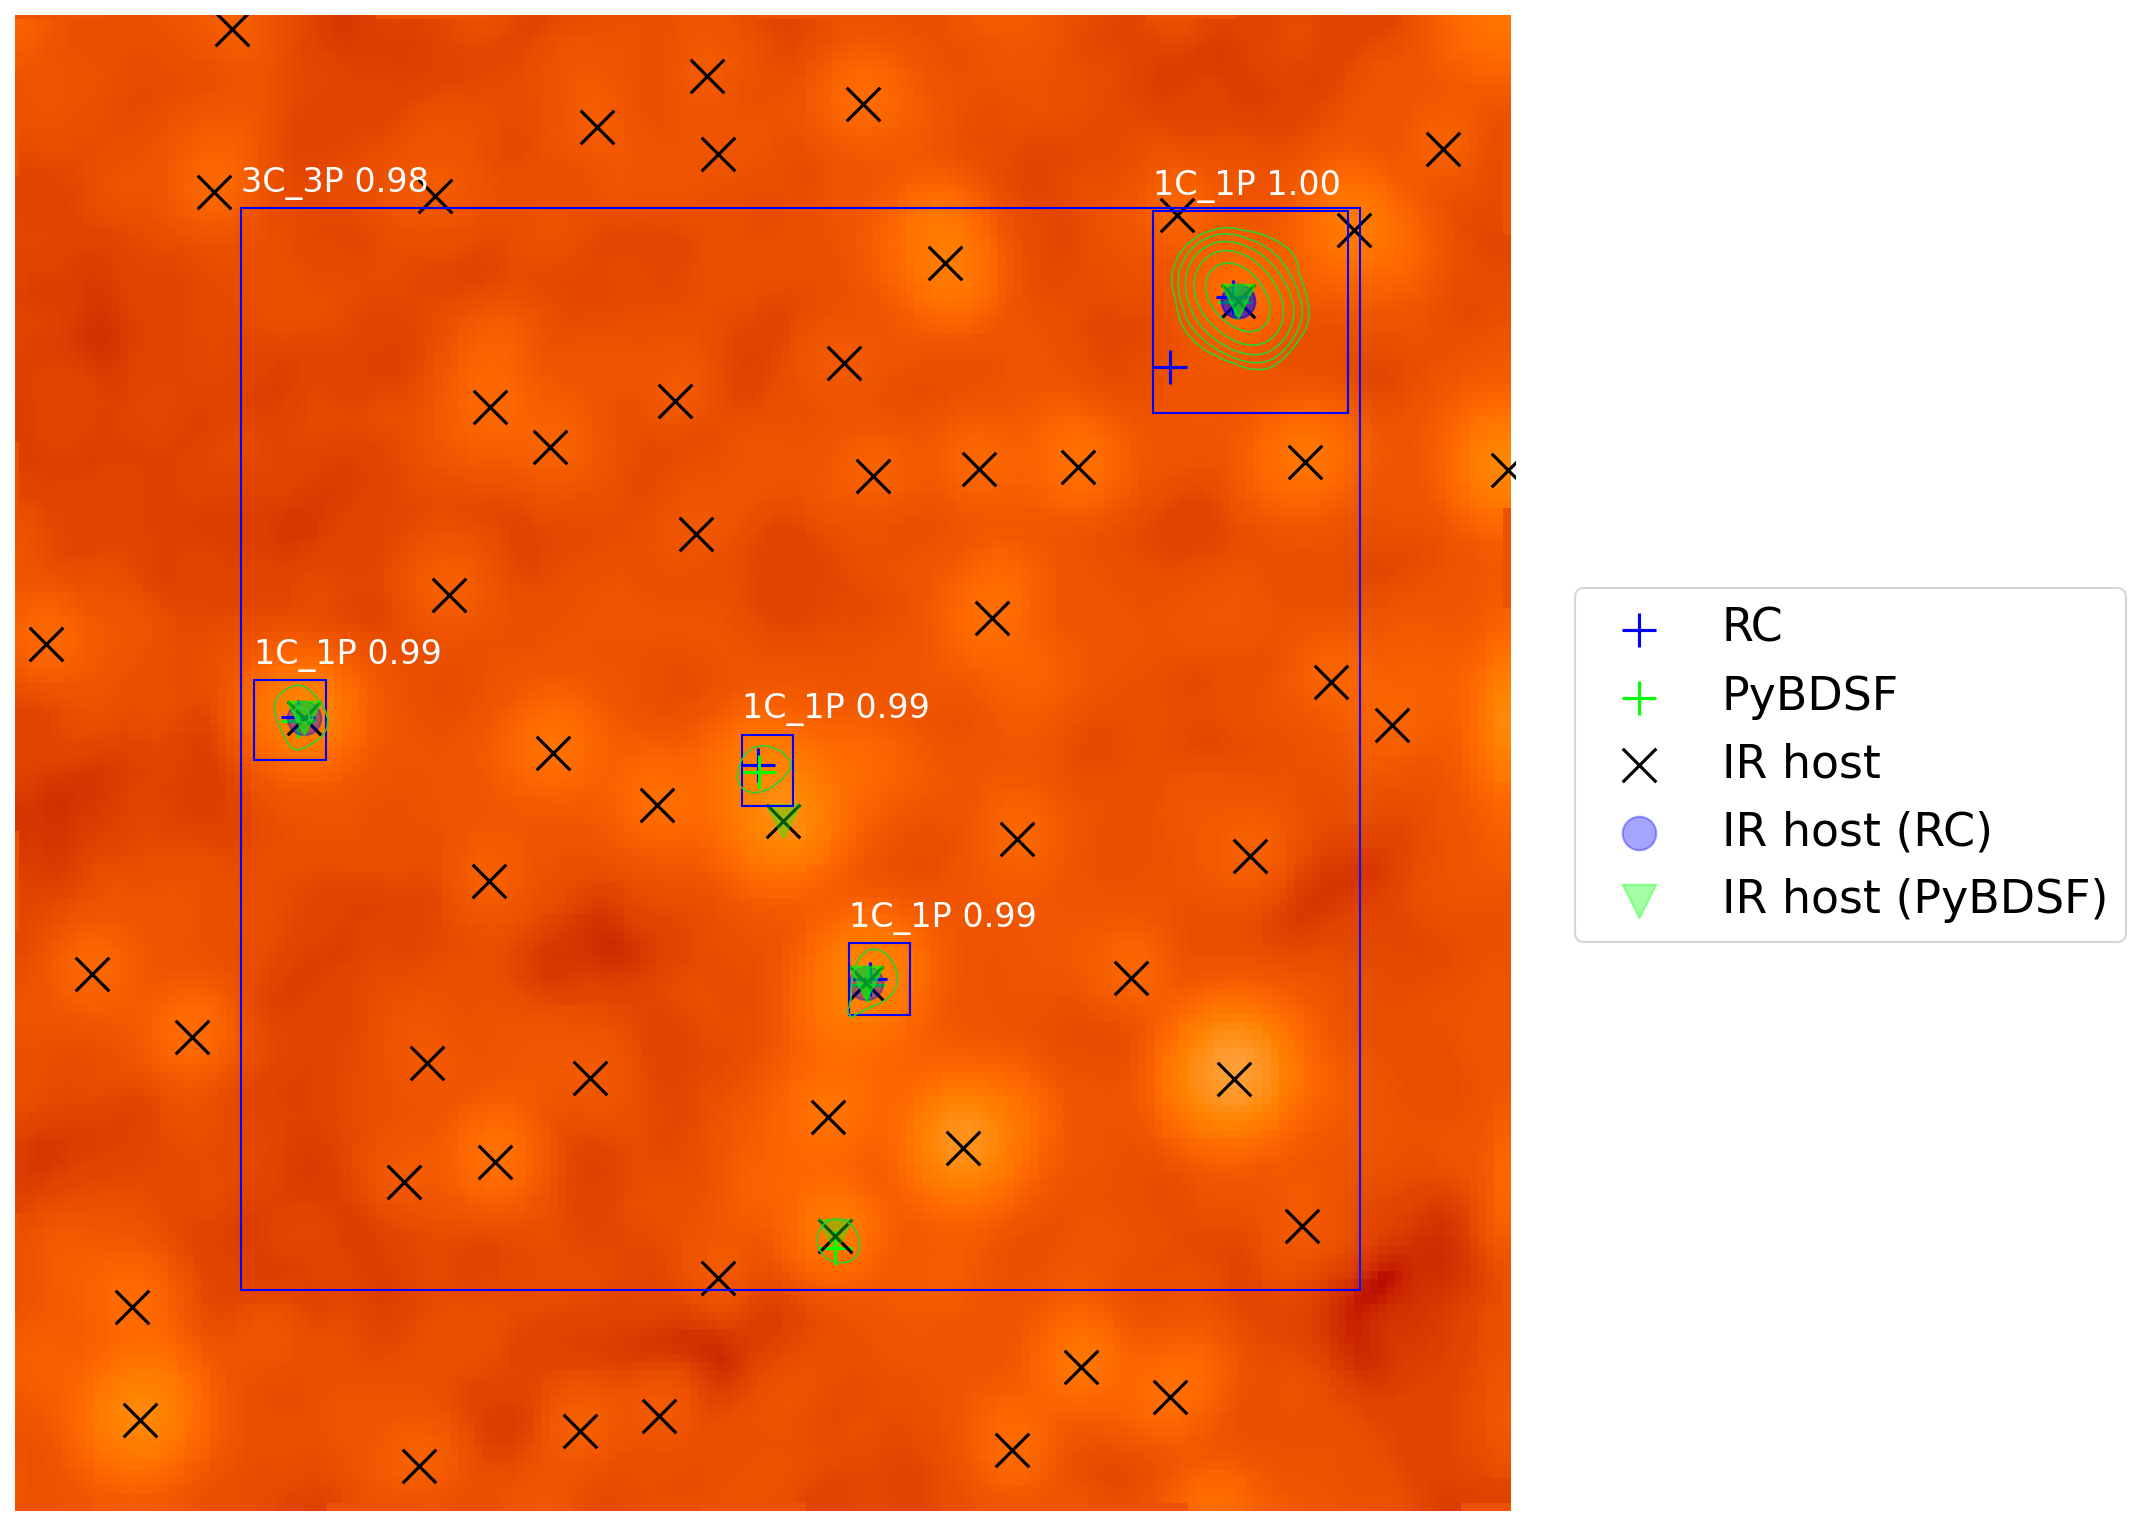

In [22]:
ClaRAN_file = "/idia/users/cmofokeng/data/gmrt/output_gmrt/gmrt_en1w610_clipped_1100.csv"
ir_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_1100_infrared.png"
radio_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_1100_logminmax.png"
hosts_file = "/idia/users/cmofokeng/data/gmrt/split_fits/position/gmrt_en1w610_clipped_1100.csv"
fits_f = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_1100.fits"
fits_f_w = "/idia/users/cmofokeng/data/gmrt/split_fits/wise_1deg/gmrt_en1w610_clipped_1100_0_wise_regrid.fits"
rad_catalog = "/idia/users/cmofokeng/data/gmrt/en1w610-5sg9-clean-offset.vot"
a = overlay_centroids(ClaRAN_file,ir_img,radio_img,fits_f,fits_f_w,hosts_file,rad_catalog)

(1, 2)
(1, 2, 1)
(2, 2)


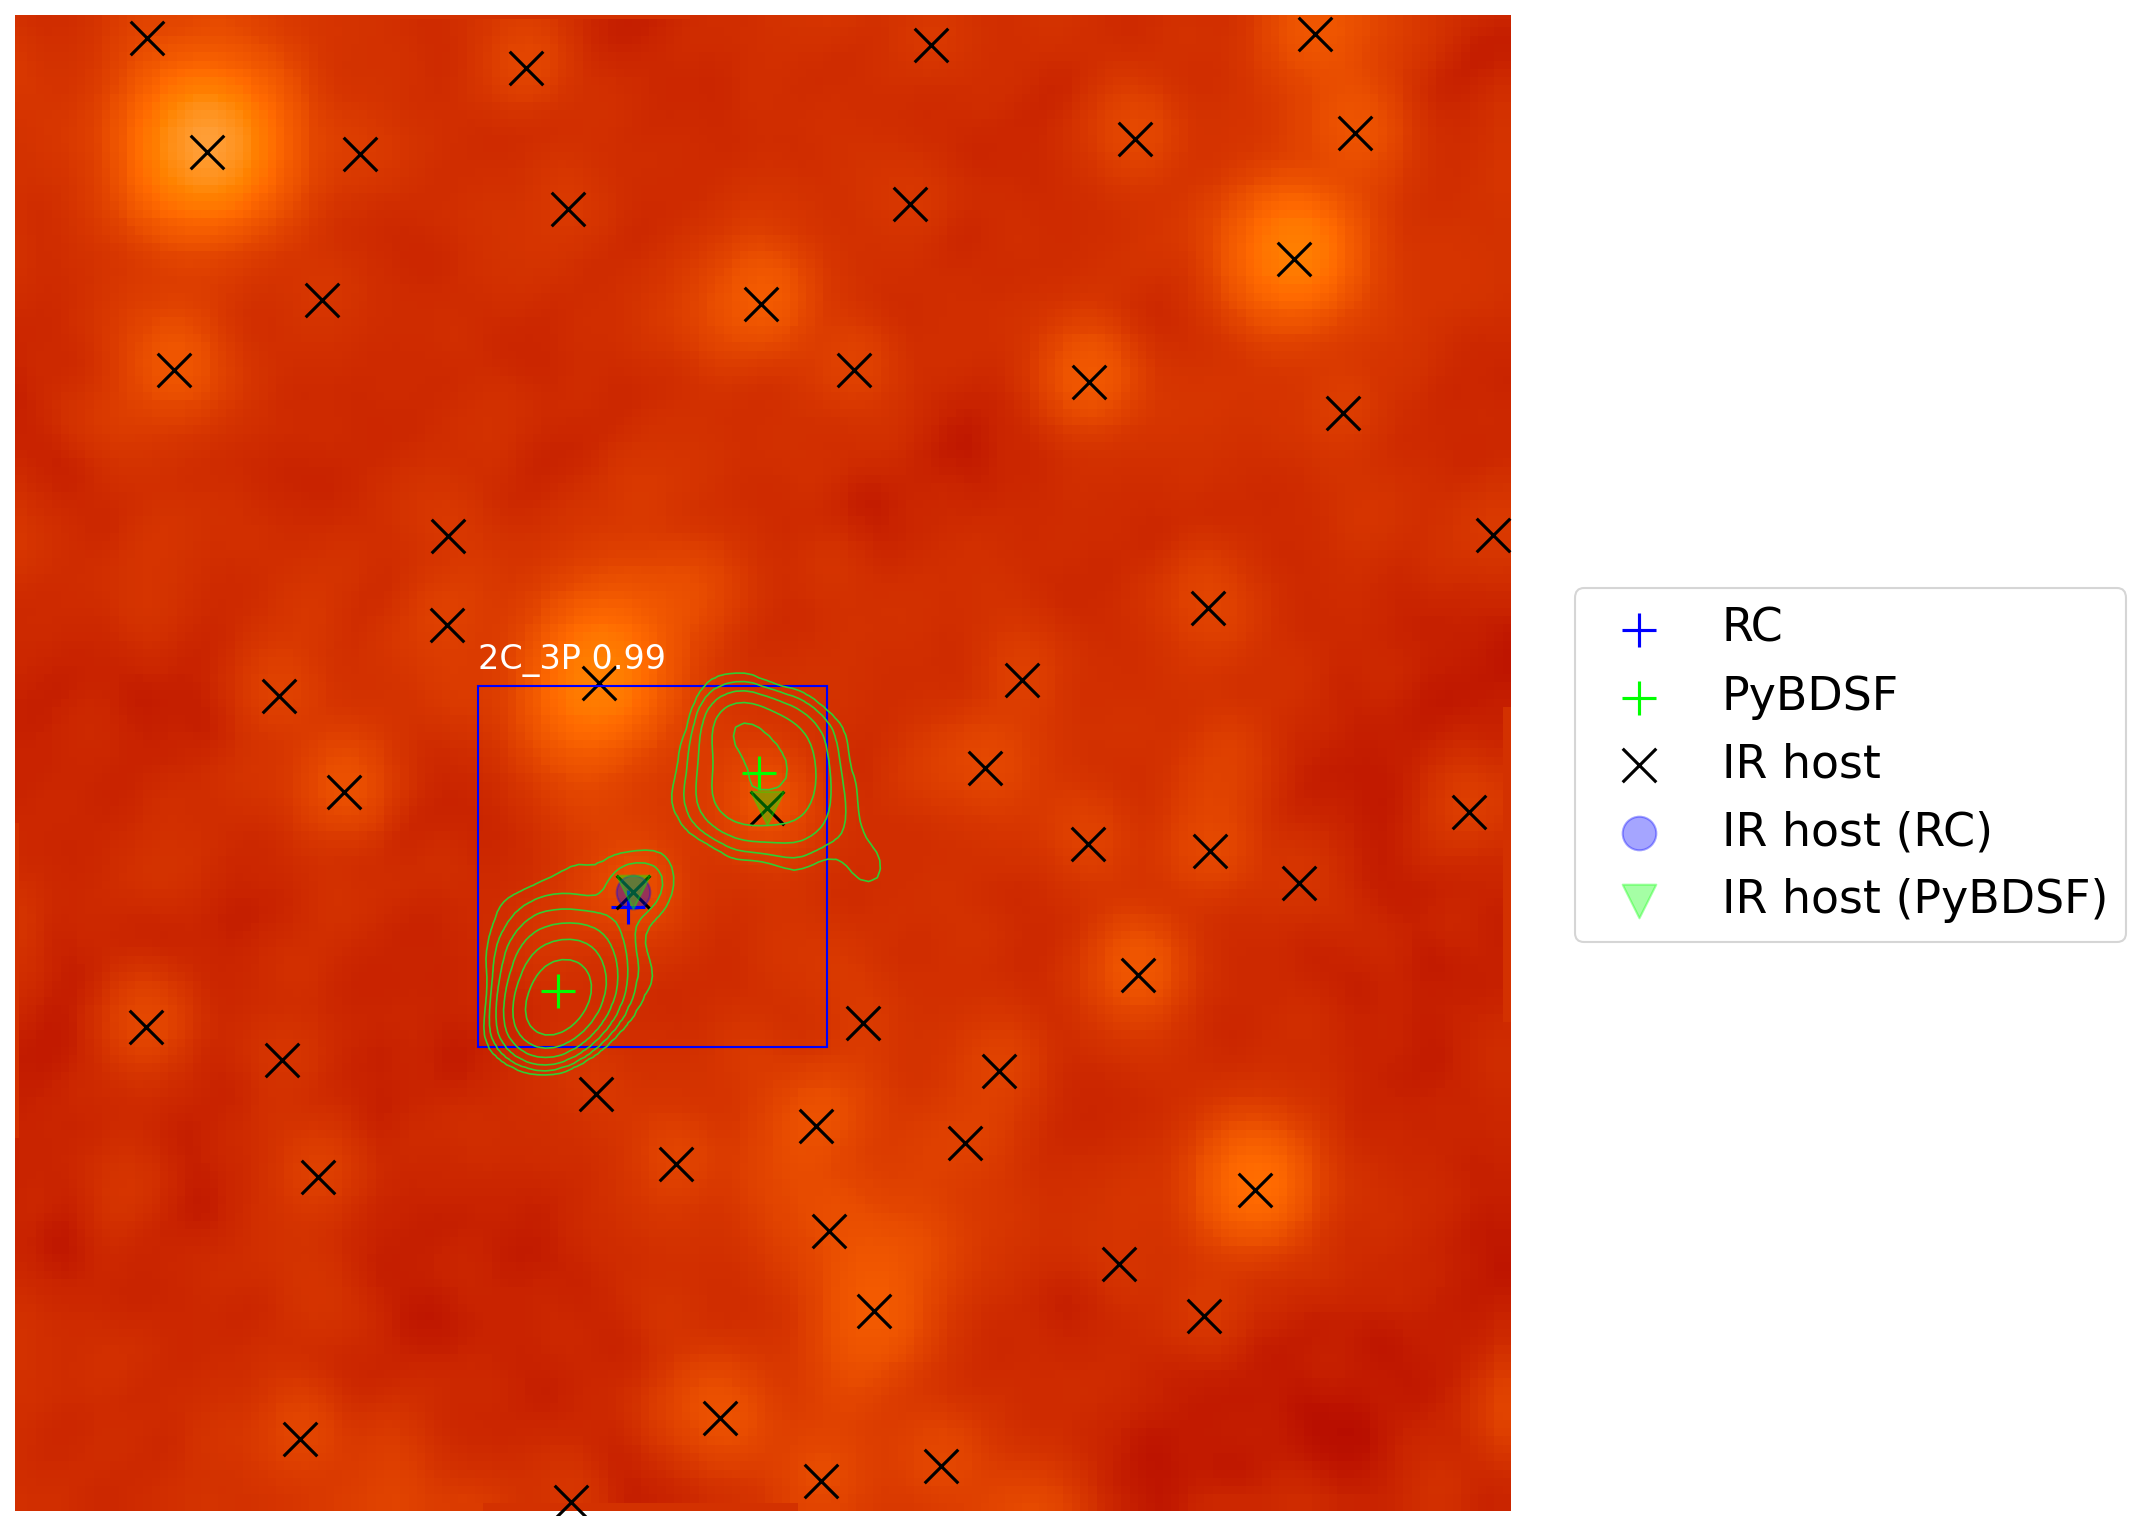

In [23]:
ClaRAN_file = "/idia/users/cmofokeng/data/gmrt/output_gmrt/gmrt_en1w610_clipped_4879.csv"
ir_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_4879_infrared.png"
radio_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_4879_logminmax.png"
hosts_file = "/idia/users/cmofokeng/data/gmrt/split_fits/position/gmrt_en1w610_clipped_4879.csv"
fits_f = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_4879.fits"
fits_f_w = "/idia/users/cmofokeng/data/gmrt/split_fits/wise_1deg/gmrt_en1w610_clipped_4879_0_wise_regrid.fits"
a = overlay_centroids(ClaRAN_file,ir_img,radio_img,fits_f,fits_f_w,hosts_file,rad_catalog)

(1, 2)
(1, 2, 1)
(2, 2)


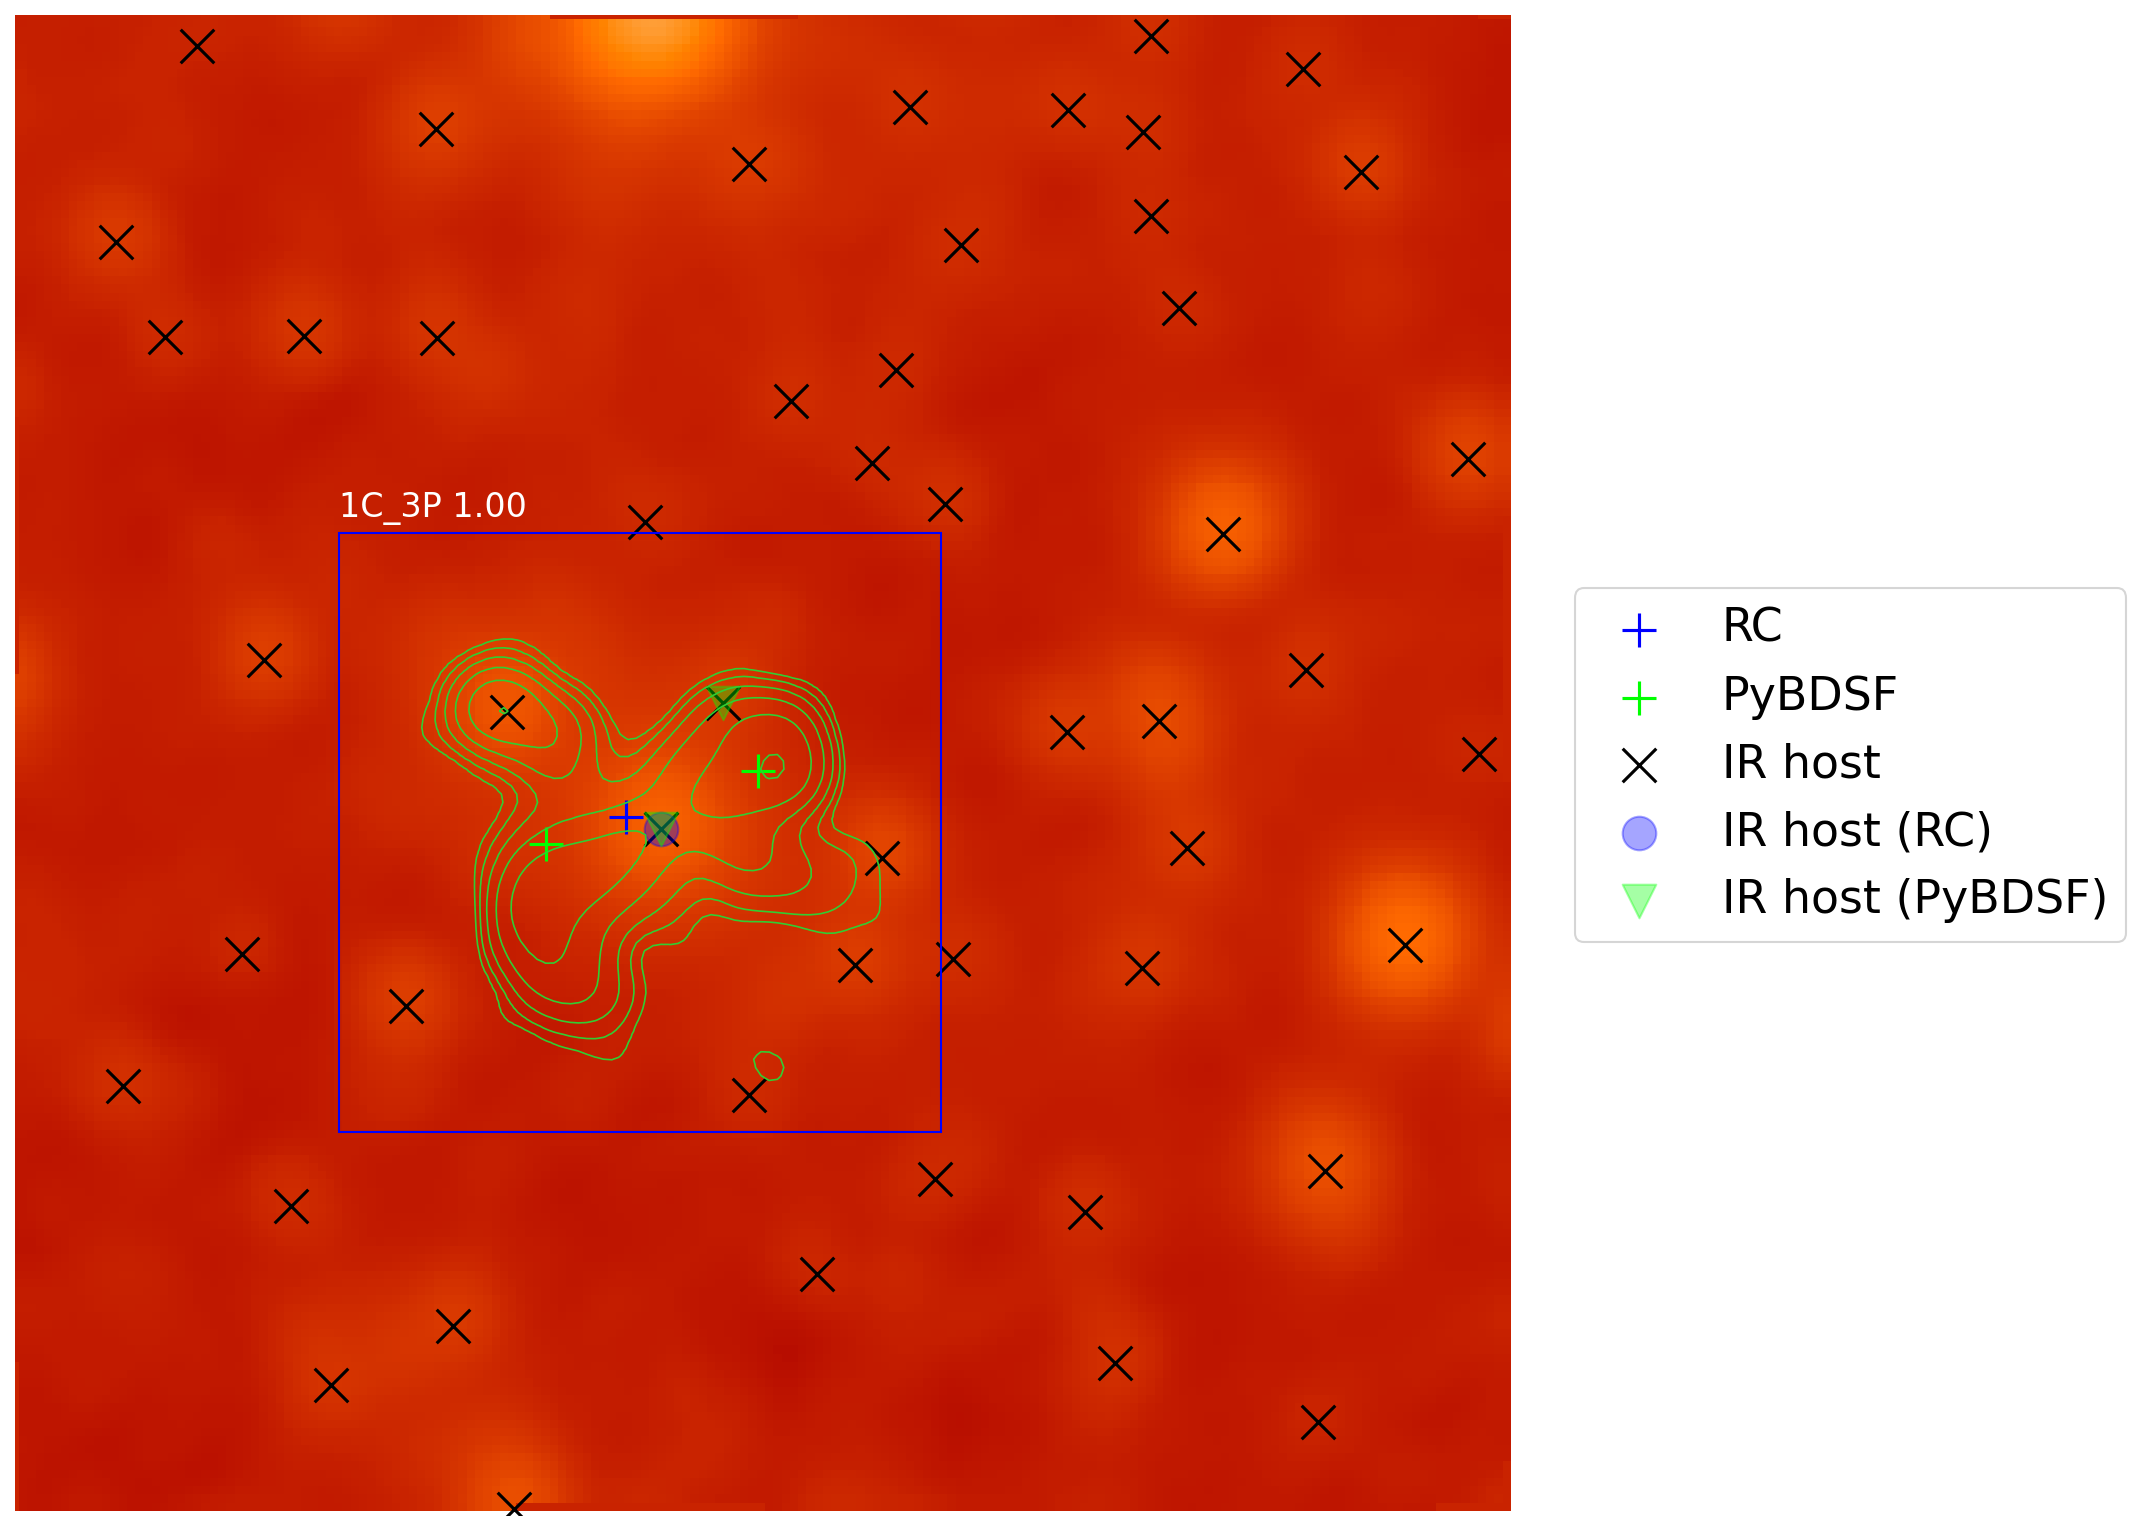

In [24]:
ClaRAN_file = "/idia/users/cmofokeng/data/gmrt/output_gmrt/gmrt_en1w610_clipped_2717.csv"
ir_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_2717_infrared.png"
radio_img = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_2717_logminmax.png"
hosts_file = "/idia/users/cmofokeng/data/gmrt/split_fits/position/gmrt_en1w610_clipped_2717.csv"
fits_f = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_2717.fits"
fits_f_w = "/idia/users/cmofokeng/data/gmrt/split_fits/wise_1deg/gmrt_en1w610_clipped_2717_0_wise_regrid.fits"
overlay_centroids(ClaRAN_file,ir_img,radio_img,fits_f,fits_f_w,hosts_file,rad_catalog)

PS: Some examples shown above are not in the final (post filtering processes) catalog due to being suppressed, however they are presented to show that whenever CLARAN detects a source, its source position and IR counterpart can be recovered using the implemented source characterization pipeline.  